In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [5]:

v = deepcopy(uv)


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [8]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [9]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [10]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [11]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [12]:

ants = uv.antenna_numbers

ant_delay = {}

for i in ants:
    
    ant_delay[i] = np.random.normal(0,2e-7)
    #ant_delay[i] = np.random.randint(10)
    

In [13]:

def generate_random_data(x_width,xants):    
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_width = 0.5
    
    i_amp = 0
    
    n_amp = 0
    
    n_width = 0.1

    x_amp = 0
    
    snr = 10
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            indices = v.antpair2ind(j[0],j[1])
        
            i_sig = signal(i_amp,i_width,j)
            
            i_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            flag_xant = False
            
            for xant in xants:
                
                if ((j[0] == xant) or (j[1] == xant)):

                    x_sig = signal(x_amp,x_width,j)

                    x_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])

                    x_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])

                    x_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])

                    x_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])

                    norm_power = float(s_width**2)

                    new_power = float(norm_power + i_width**2 + x_width**2)

                    ratio = np.sqrt(norm_power/new_power)

                    sigs = (sig + i_sig + x_sig) * ratio
                    
                    flag_xant = True
                    
                    break
                    
            if not flag_xant:

                norm_power = float(s_width**2)

                new_power = float(norm_power + i_width**2)

                ratio = np.sqrt(norm_power/new_power)

                sigs = (sig + i_sig) * ratio
            
            noi = noise(n_amp,n_width)
        
            noi_power = np.mean(np.abs(noi))
        
            sig_power = np.mean(np.abs(sigs))
        
            noi_mod = snr/(sig_power/noi_power)
        
            noi /= noi_mod
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
        
        new_power = float(norm_power + i_width**2)
        
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig) * ratio
        
        indices = v.antpair2ind(k[0],k[1])
        
        noi = noise(n_amp,n_width)
        
        noi_power = np.mean(np.abs(noi))
        
        sig_power = np.mean(np.abs(sigs))
        
        noi_mod = snr/(sig_power/noi_power)
        
        noi /= noi_mod
        
        visibility = sig
        
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array

In [14]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [15]:
def new_red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):

    # Compute power correlations and assign them to each antenna
    autoPower = new_compute_median_auto_power_dict(data, pols, reds)
    antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
                (ant, antpol) not in xants}
    antCounts = deepcopy(antCorrs)
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            # This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n, (ant0_i, ant0_j) in enumerate(bls):
                        data0 = data.get_data(ant0_i, ant0_j, pol0)
                        for (ant1_i, ant1_j) in bls[n + 1:]:
                            data1 = data.get_data(ant1_i, ant1_j, pol1)
                            corr = np.median(np.mean(np.abs(data0) * np.abs(data1),axis=1))
                            
                            corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
                                            autoPower[ant1_i, ant1_j, pol1])
                            antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
                                            (ant1_i, pol1[0]), (ant1_j, pol1[1])]
                            if not np.any([(ant, antpol) in xants for ant, antpol
                                           in antsInvolved]):
                                # Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i, pol0[0]),
                                                    (ant1_i, pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
                                for ant, antpol in antsInvolved:
                                    antCorrs[(ant, antpol)] += corr
                                    antCounts[(ant, antpol)] += 1

    # Compute average and return
    for key, count in antCounts.items():
        if count > 0:
            antCorrs[key] /= count
        else:
            # Was not found in reds, should not have a valid metric.
            antCorrs[key] = np.NaN
    if rawMetric:
        return antCorrs
    else:
        return per_antenna_modified_z_scores(antCorrs)


In [16]:

def generate_random_array(width_array,xant_array):
    
    new_array = list(np.zeros((10,10,2)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            x_width = float(width_array[i][j][0])
            
            xants = int(width_array[i][j][1])
            
            xants_temp = xant_array[:xants]
            
            temp_array = generate_random_data(x_width,xants_temp)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            count_good = 0
            
            count_bad = 0

            for key in z_scores.keys():
                
                if z_scores[key] <= -5.0:
                    
                    flag_good = False
                    
                    for xant in xants_temp:
                    
                        if int(xant) == int(key[0]):

                            count_good += 1
                            
                            flag_good = True
                            
                            break
                            
                    if not flag_good:
                        
                        count_bad += 1
            
            new_array[i][j][0] = count_good
            
            new_array[i][j][1] = count_bad
            
    return new_array
    


In [17]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [18]:

x_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

xants = [1,2,3,4,5,6,7,8,9,10]

xant_array= np.array([0,1,2,11,12,39,50,51,52,121])


In [19]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (x_vals[i],xants[j])


In [20]:
print input_array

[[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)], [(0.25, 1), (0.25, 2), (0.25, 3), (0.25, 4), (0.25, 5), (0.25, 6), (0.25, 7), (0.25, 8), (0.25, 9), (0.25, 10)], [(0.5, 1), (0.5, 2), (0.5, 3), (0.5, 4), (0.5, 5), (0.5, 6), (0.5, 7), (0.5, 8), (0.5, 9), (0.5, 10)], [(0.75, 1), (0.75, 2), (0.75, 3), (0.75, 4), (0.75, 5), (0.75, 6), (0.75, 7), (0.75, 8), (0.75, 9), (0.75, 10)], [(1.0, 1), (1.0, 2), (1.0, 3), (1.0, 4), (1.0, 5), (1.0, 6), (1.0, 7), (1.0, 8), (1.0, 9), (1.0, 10)], [(1.25, 1), (1.25, 2), (1.25, 3), (1.25, 4), (1.25, 5), (1.25, 6), (1.25, 7), (1.25, 8), (1.25, 9), (1.25, 10)], [(1.5, 1), (1.5, 2), (1.5, 3), (1.5, 4), (1.5, 5), (1.5, 6), (1.5, 7), (1.5, 8), (1.5, 9), (1.5, 10)], [(2.0, 1), (2.0, 2), (2.0, 3), (2.0, 4), (2.0, 5), (2.0, 6), (2.0, 7), (2.0, 8), (2.0, 9), (2.0, 10)], [(3.0, 1), (3.0, 2), (3.0, 3), (3.0, 4), (3.0, 5), (3.0, 6), (3.0, 7), (3.0, 8), (3.0, 9), (3.0, 10)], [(4.0, 1), (4.0, 2), (4.0, 3), (4.0, 4), (4.0, 5), (4.0, 6), (

In [21]:

#holder_array_nm_xants = generate_random_array(input_array,xant_array)

#np.savez('holder_array_nm_xants.npz',holder_array_nm_xants)


In [22]:

data = np.load('holder_array_nm_xants.npz')

holder_array = data['arr_0']

#holder_array = holder_array_nm_xants


In [23]:
print holder_array

[[[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 1.  0.]
  [ 1.  0.]
  [ 1.  0.]
  [ 1.  0.]
  [ 1.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 1.  0.]
  [ 2.  0.]
  [ 4.  0.]
  [ 0.  0.]
  [ 6.  0.]
  [ 2.  0.]
  [ 1.  0.]
  [ 2.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 2.  0.]
  [ 3.  0.]
  [ 6.  0.]
  [ 3.  0.]
  [ 2.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 2.  0.]
  [ 4.  0.]
  [ 6.  0.]
  [ 2.  0.]
  [ 4.  0.]
  [ 2.  0.]
  [ 0.  0.]
  [ 4.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 2.  0.]
  [ 4.  0.]
  [ 3.  0.]
  [ 5.  0.]
  [ 5.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 0.  0.]
  [ 2.  0.]]

 [[ 1.  0.]
  [ 2.  0.]
  [ 1.  0.]
  [ 4.  0.]
  [ 1.  0.]
  [ 1.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 2.  0.]


In [25]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 2.0, 4.0, 0.0, 6.0, 2.0, 1.0, 2.0, 0.0, 0.0], [2.0, 3.0, 6.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.0, 4.0, 6.0, 2.0, 4.0, 2.0, 0.0, 4.0, 0.0, 0.0], [2.0, 4.0, 3.0, 5.0, 5.0, 0.0, 0.0, 1.0, 0.0, 2.0], [1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.0, 2.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 0.0], [0.0, 4.0, 2.0, 3.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0]]


In [26]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


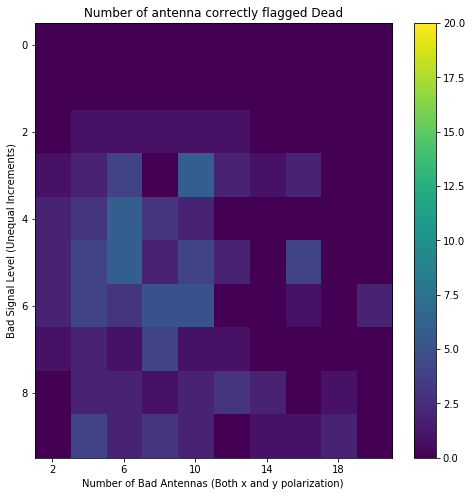

In [39]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto',vmax = 20)
plt.title('Number of antenna correctly flagged Dead')
plt.ylabel('Bad Signal Level (Unequal Increments)')
plt.xlabel('Number of Bad Antennas (Both x and y polarization)')
plt.xticks(np.arange(0,10,2),(np.arange(0,10,2)+1)*2)
plt.colorbar()
plt.show()


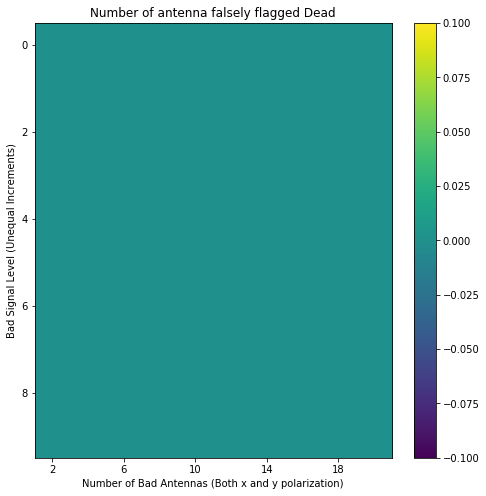

In [38]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto')
plt.title('Number of antenna falsely flagged Dead')
plt.ylabel('Bad Signal Level (Unequal Increments)')
plt.xlabel('Number of Bad Antennas (Both x and y polarization)')
plt.xticks(np.arange(0,10,2),(np.arange(0,10,2)+1)*2)
plt.colorbar()
plt.show()


In [29]:

flag_ratio_array = np.zeros((10,10))

flag_diff_array = np.zeros((10,10))

total_diff_array = np.zeros((10,10))

for i in range(len(array_1)):
    
    for j in range(len(array_1[0])):
        
        flag_diff_array[i][j] = array_1[i][j] - 2*xants[j]
        
        total_diff_array[i][j] = (array_1[i][j]+array_2[i][j]) - 2*xants[j]
        
        
        if array_1[i][j] == 0:
            
            flag_ratio_array[i][j] = array_2[i][j]
            
        else:
        
            flag_ratio_array[i][j] = array_2[i][j]/array_1[i][j]


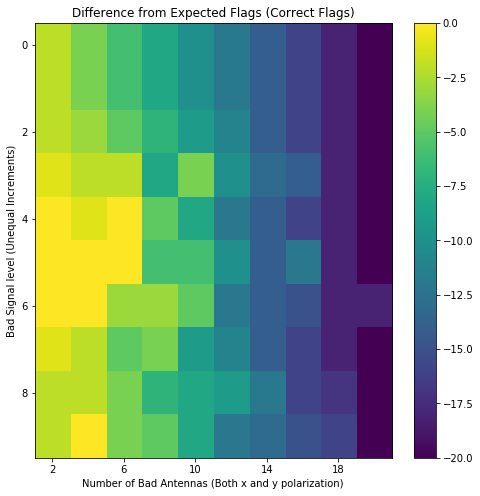

In [35]:

plt.figure(figsize=(8,8))
plt.imshow(flag_diff_array,aspect='auto')
plt.title('Difference from Expected Flags (Correct Flags)')
plt.ylabel('Bad Signal level (Unequal Increments)')
plt.xlabel('Number of Bad Antennas (Both x and y polarization)')
plt.xticks(np.arange(0,10,2),(np.arange(0,10,2)+1)*2)
plt.colorbar()
plt.show()


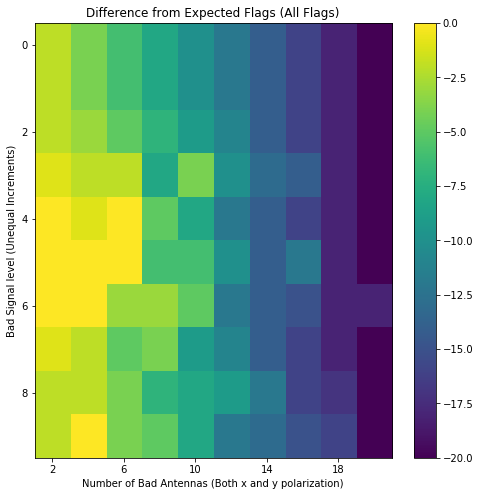

In [36]:

plt.figure(figsize=(8,8))
plt.imshow(total_diff_array,aspect='auto')
plt.title('Difference from Expected Flags (All Flags)')
plt.ylabel('Bad Signal level (Unequal Increments)')
plt.xlabel('Number of Bad Antennas (Both x and y polarization)')
plt.xticks(np.arange(0,10,2),(np.arange(0,10,2)+1)*2)
plt.colorbar()
plt.show()
